In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pqr

# Загрузка и предобработка данных + подготовка дашборда

In [2]:
prices = pd.read_csv("factors/usa/close_price.csv", index_col=0, parse_dates=True)
prices = prices.replace(0, np.nan)
prices = prices.iloc[:-1]

In [3]:
universe = prices > 10
returns_calculator = pqr.utils.partial(
    pqr.calculate_returns,
    universe_returns=pqr.prices_to_returns(prices),
)

benchmark = pqr.Benchmark.from_universe(
    universe=universe,
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
)

In [4]:
table = pqr.metrics.Table()
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.mean_return,
        statistics=True,
        annualizer=1,
    ),
    multiplier=100,
    precision=2,
    name="Monthly Mean Return, %",
)
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.volatility,
        annualizer=1,
    ),
    multiplier=100,
    precision=2,
    name="Monthly Volatility, %",
)
table.add_metric(
    pqr.metrics.max_drawdown,
    multiplier=100,
    name="Maximum Drawdown, %",
)
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.mean_excess_return,
        benchmark=benchmark,
        statistics=True,
        annualizer=1,
    ),
    multiplier=100,
    precision=2,
    name="Monthly Mean Excess Return, %",
)
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.alpha,
        benchmark=benchmark,
        statistics=True,
        annualizer=1,
    ),
    multiplier=100,
    precision=2,
    name="Monthly Alpha, %",
    
)
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.beta,
        benchmark=benchmark,
        statistics=True,
    ),
    precision=2,
    name="Monthly Beta, %",
)

fig = pqr.metrics.Figure(
    pqr.metrics.compounded_returns,
    name="Compounded Returns",
    benchmark=benchmark,
    log_scale=True,
    kwargs={
        "figsize": (10, 6),
    }
)

summary = pqr.metrics.Dashboard([table, fig])

In [5]:
dynamic_transform = pqr.utils.compose(
    pqr.utils.partial(pqr.factors.filter, universe=universe),
    pqr.utils.partial(pqr.factors.look_back_pct_change, period=12),
    pqr.utils.partial(pqr.factors.hold, period=12)
)
mom = dynamic_transform(prices)

# Строим time-series факторную модель

,Winners,Losers
"Monthly Mean Return, %",0.75*** (4.12),0.69*** (2.92)
"Monthly Volatility, %",4.35,5.67
"Maximum Drawdown, %",-50.01,-47.67
"Monthly Mean Excess Return, %",-0.02 (-0.39),-0.08 (-0.76)
"Monthly Alpha, %",0.09 (1.65),-0.11 (-1.06)
"Monthly Beta, %",0.86*** (81.04),1.04*** (47.60)


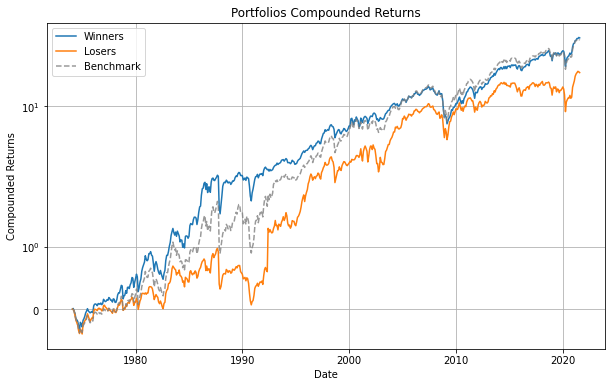

In [6]:
portfolios_ts = pqr.factors.backtest_factor_portfolios(
    factor=mom,
    strategies=pqr.factors.split_time_series([0], "more"),
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
)

summary.display(portfolios_ts)

# Строим quantile факторную модель с 5 квантилями

,Winners,Neutral 1,Neutral 2,Neutral 3,Losers
"Monthly Mean Return, %",0.71*** (3.27),0.77*** (4.45),0.76*** (4.34),0.62*** (3.24),0.80*** (2.63)
"Monthly Volatility, %",5.19,4.13,4.21,4.56,7.24
"Maximum Drawdown, %",-51.77,-45.61,-47.09,-53.00,-55.24
"Monthly Mean Excess Return, %",-0.06 (-0.77),-0.00 (-0.05),-0.01 (-0.12),-0.15 (-1.95),0.02 (0.13)
"Monthly Alpha, %",-0.06 (-0.67),0.14*** (2.66),0.14** (2.12),-0.05 (-0.66),-0.20 (-1.25)
"Monthly Beta, %",0.99*** (58.95),0.81*** (73.03),0.80*** (58.41),0.86*** (56.44),1.28*** (40.30)


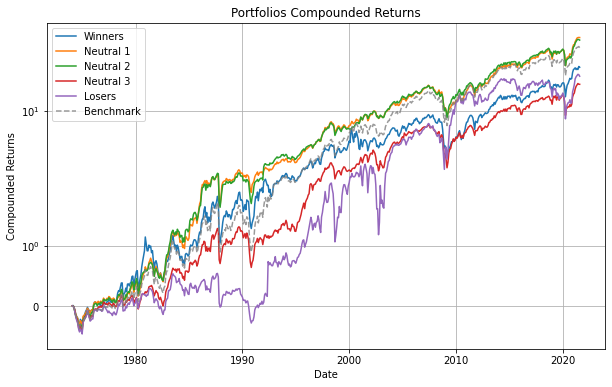

In [7]:
portfolios_q = pqr.factors.backtest_factor_portfolios(
    factor=mom,
    strategies=pqr.factors.split_quantiles(5, "more"),
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
)

summary.display(portfolios_q)

# Пробуем OP-test

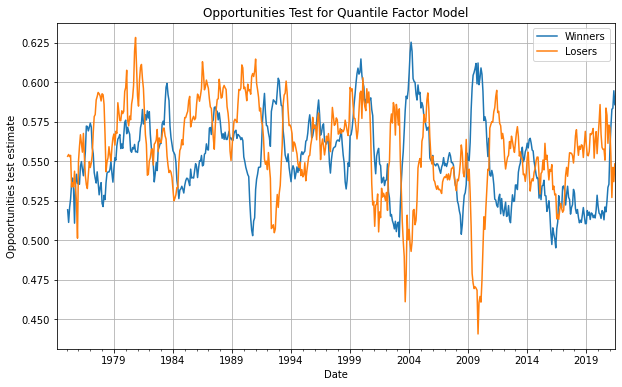

In [8]:
plt.figure(figsize=(10, 6))

wop = pqr.tests.opportunities_test(
    base_portfolio=portfolios_q[0],
    prices=prices,
    universe=universe,
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
)
lop = pqr.tests.opportunities_test(
    base_portfolio=portfolios_q[-1],
    prices=prices,
    universe=universe,
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
)

wop.rolling(12).mean().plot(label=portfolios_q[0].name)
lop.rolling(12).mean().plot(label=portfolios_q[-1].name)

plt.title("Opportunities Test for Quantile Factor Model")
plt.xlabel("Date")
plt.ylabel("Oppoortunities test estimate")
plt.legend()
plt.grid();

# Double time-series momentum

In [9]:
_, benchmark_returns = pqr.utils.align(mom, benchmark.returns)
benchmark_returns = benchmark_returns.to_numpy()[:, np.newaxis]
double_ts_portfolio = pqr.Portfolio.backtest(
    longs=pqr.factors.time_series(mom, min_threshold=0) & (benchmark_returns > 0),
    shorts=pqr.factors.time_series(mom, max_threshold=0) & (benchmark_returns < 0),
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
    name="Double TS Momentum",
)

<AxesSubplot:xlabel='Double TS Momentum'>

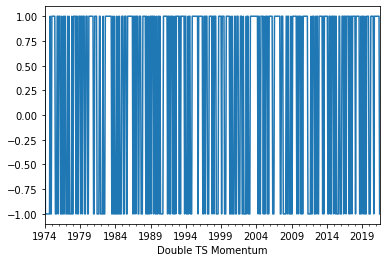

In [10]:
double_ts_portfolio.holdings.sum(axis=1).plot()

,Winners,Losers,Double TS Momentum
"Monthly Mean Return, %",0.75*** (4.12),0.69*** (2.92),0.83*** (3.77)
"Monthly Volatility, %",4.35,5.67,5.25
"Maximum Drawdown, %",-50.01,-47.67,-55.53
"Monthly Mean Excess Return, %",-0.02 (-0.39),-0.08 (-0.76),0.06 (0.16)
"Monthly Alpha, %",0.09 (1.65),-0.11 (-1.06),1.10*** (5.21)
"Monthly Beta, %",0.86*** (81.04),1.04*** (47.60),-0.35*** (-8.11)


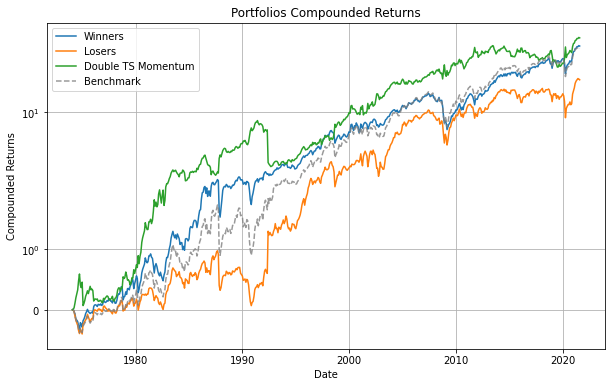

In [11]:
summary.display(portfolios_ts + [double_ts_portfolio])

Использование методики double time-series momentum действительно показало себя лучше простого моментума за счет тайминга, но есть подозрение, что с введением ограничения на шорты и комиссий, это уйдет, и получится либо такой же моментум, либо даже чуть хуже.